In [26]:
import qrpm_funcs as qf
import numpy as np

seriesnames = ['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2',
               'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']
maturities = qf.TenorsFromNames(seriesnames)
lastday = qf.LastYearEnd()
firstday = qf.LastYearEnd(int(lastday[:4]) - 1)
dates_dirty, prices_dirty = qf.GetFREDMatrix(seriesnames, startdate=firstday, enddate=lastday)
# remove no-data periods
nan_list = [any(np.isnan(p)) for p in prices_dirty]
prices = [prices_dirty[i] for i in range(len(prices_dirty)) if not nan_list[i]]
dates = [dates_dirty[i] for i in range(len(dates_dirty)) if not nan_list[i]]

Explained variance:  0.9435231626784429


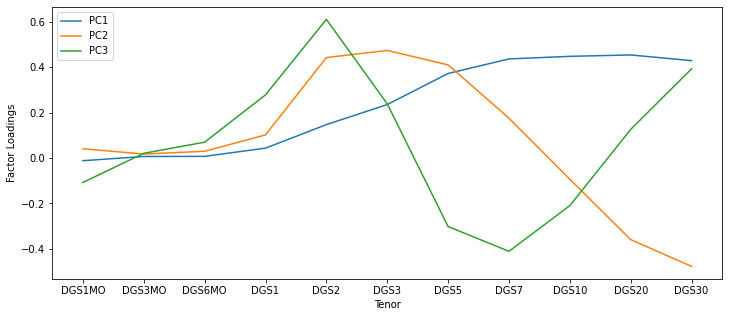

In [27]:
from numpy import linalg as la
import matplotlib.pyplot as plt

prices = np.array(prices)
change = prices[1:,:] - prices[:-1,:]
COV = np.cov(change.T)
eigenvalues , eigenvectors = la.eigh(COV)
eigenvectors = [eigenvectors[:,i] for i in range(len(eigenvalues))]
Z = zip(eigenvalues,eigenvectors)
Z = sorted(Z,key=lambda x: x[0],reverse=True)
sorted_eigenvalues = [item[0] for item in Z]
sorted_eigenvectors = [item[1] for item in Z]
print("Explained variance: ", sum(sorted_eigenvalues[:3])/sum(sorted_eigenvalues))
plt.figure(figsize=(12, 5))
l1, = plt.plot(sorted_eigenvectors[0])
l2, = plt.plot(sorted_eigenvectors[1])
l3, = plt.plot(sorted_eigenvectors[2])
plt.xlabel("Tenor")
plt.ylabel("Factor Loadings")
plt.xticks(range(11),seriesnames)
plt.legend(handles=[l1,l2,l3],labels=['PC1','PC2','PC3'])
plt.show()

[ 2.77943429e+01  2.09388148e+00 -2.08229988e+00 -4.81979152e-03]


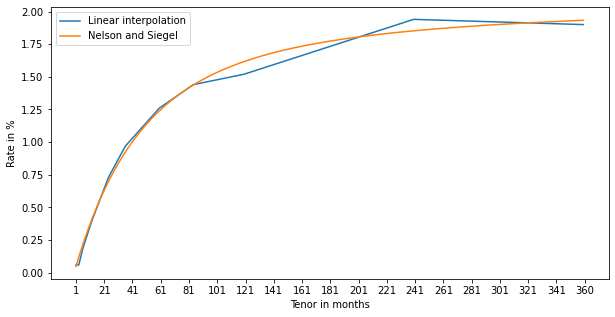

In [14]:
curve = np.array(prices[-1])
x = np.linspace(1,360,360)
months = np.array([1,3,6,12,24,36,60,84,120,240,360])
from scipy import interpolate
f=interpolate.interp1d(months,curve,kind='linear')
linear_curve = f(x)
plt.figure(figsize=(10, 5))
l1,=plt.plot(linear_curve)
plt.xlabel("Tenor in months")
plt.ylabel("Rate in %")
plt.xticks(range(0,361,20),[20*i+1 for i in range(18)]+[360])

def N_S_loss(para): # f ndarray
    f = np.linspace(1,360,360)
    outcome = para[1]+para[2]*para[0]/f*(1-np.exp(-f/para[0]))+para[3]*para[0]/f*(1-np.exp(-f/para[0])*(1+f/para[0]))
    return np.sum(abs(outcome-linear_curve))

def N_S(para): # f ndarray
    f = np.linspace(1,360,360)
    outcome = para[1]+para[2]*para[0]/f*(1-np.exp(-f/para[0]))+para[3]*para[0]/f*(1-np.exp(-f/para[0])*(1+f/para[0]))
    return outcome
from scipy.optimize import minimize
result = minimize(N_S_loss,np.array([1,2,-2,1.5]))
estimated = result.x
print(estimated)
l2,=plt.plot(N_S(estimated))
plt.legend(handles=[l1,l2],labels=['Linear interpolation','Nelson and Siegel'])
plt.show()